In [2]:
# WORLD BANK EXTRACTION CELL
# --------------------------------------------------------
# Converts ALL World Bank API files in data/raw/ into
# clean long-format tables and merges them into:
#   data/processed/worldbank_core.csv
# --------------------------------------------------------

import os, glob, zipfile
import pandas as pd
import pycountry

RAW = "data/raw"
PROC = "data/processed"
os.makedirs(PROC, exist_ok=True)

# -------------------------------
# Helper: ISO country mapping
# -------------------------------
def country_to_iso3(name):
    """Convert country names to ISO3 with fallback manual mapping."""
    if pd.isna(name): return None
    try:
        return pycountry.countries.lookup(name).alpha_3
    except:
        manual = {
            "Korea, Rep.":"KOR","Korea, Dem. People's Rep.":"PRK",
            "Czech Republic":"CZE","Russian Federation":"RUS",
            "United States":"USA","Viet Nam":"VNM","Iran, Islamic Rep.":"IRN",
            "Syrian Arab Republic":"SYR","Lao PDR":"LAO","Slovak Republic":"SVK",
            "Bolivia (Plurinational State of)":"BOL","Venezuela (Bolivarian Republic of)":"VEN",
            "Yemen, Rep.":"YEM","Egypt, Arab Rep.":"EGY"
        }
        return manual.get(str(name).strip(), None)

def iso2_to_iso3(x):
    try:
        return pycountry.countries.get(alpha_2=x).alpha_3 if pd.notna(x) else None
    except:
        return None

# -------------------------------
# Helper: read World Bank API CSV or ZIP
# -------------------------------
def read_wb_api(path):
    """Reads either a ZIP or CSV/XLSX World Bank API file."""
    if path.lower().endswith(".zip"):
        with zipfile.ZipFile(path, 'r') as z:
            api_files = [f for f in z.namelist() if f.startswith("API_") and f.endswith(".csv")]
            if not api_files:
                raise FileNotFoundError("No API_*.csv inside zip: " + path)
            with z.open(api_files[0]) as f:
                return pd.read_csv(f, skiprows=4)
    else:
        if path.lower().endswith(".csv"):
            return pd.read_csv(path, skiprows=4)
        else:
            # Excel version downloaded directly through browser → WB format starts at row 4 too
            return pd.read_excel(path, sheet_name=0, skiprows=4)

# -------------------------------
# Identify WB files
# -------------------------------
wb_files = glob.glob(os.path.join(RAW, "API_*"))
print("Detected files:", wb_files)

# Map indicator code → final column name
indicator_map = {
    "NY.GDP.MKTP.KD": "gdp_constant_2015_usd",
    "NY.GDP.PCAP.KD": "gdp_percap_constant_2015_usd",
    "SP.POP.TOTL": "population_total",
    "NY.GDP.MKTP.KD.ZG": "gdp_growth_pct",
    "SP.URB.TOTL.IN.ZS": "urban_pct"
}

indicator_dfs = {}

# -------------------------------
# Process each file
# -------------------------------
for path in wb_files:
    print("\nProcessing:", os.path.basename(path))
    df_wide = read_wb_api(path)

    # find year columns
    year_cols = [c for c in df_wide.columns if str(c).isdigit()]

    # standard WB id vars
    if 'Country Name' in df_wide.columns:
        id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
    else:
        non_years = [c for c in df_wide.columns if c not in year_cols]
        id_vars = non_years[:4]

    df_long = df_wide.melt(
        id_vars=id_vars,
        value_vars=year_cols,
        var_name='year',
        value_name='value'
    )

    df_long = df_long.rename(columns={
        id_vars[0]:'country',
        id_vars[1]:'country_iso2',
        id_vars[2]:'indicator_name',
        id_vars[3]:'indicator_code'
    })

    # detect which indicator this file represents
    detected_code = None
    fname = os.path.basename(path)

    for code in indicator_map:
        if code in fname:
            detected_code = code
            break

    if detected_code is None:
        # fallback: from CSV content
        detected_code = df_long['indicator_code'].iloc[0]

    final_col = indicator_map.get(detected_code, detected_code)

    df_long = df_long[['country','country_iso2','year','value']].copy()
    df_long = df_long.rename(columns={'value': final_col})

    # assign ISO3 codes
    df_long['iso3'] = df_long['country_iso2'].apply(iso2_to_iso3)
    df_long['iso3'] = df_long['iso3'].fillna(df_long['country'].apply(country_to_iso3))

    df_long['year'] = pd.to_numeric(df_long['year'], errors='coerce').astype('Int64')
    df_long[final_col] = pd.to_numeric(df_long[final_col], errors='coerce')

    indicator_dfs[final_col] = df_long[['iso3','country','year',final_col]].copy()
    print(f" → {final_col}: {indicator_dfs[final_col].shape[0]} rows")

# -------------------------------
# Merge all indicators
# -------------------------------
wb_merged = None

for col, dfi in indicator_dfs.items():
    if wb_merged is None:
        wb_merged = dfi
    else:
        wb_merged = wb_merged.merge(dfi, on=['iso3','year'], how='outer')
        # keep one country column
        wb_merged['country'] = wb_merged['country_x'].fillna(wb_merged['country_y'])
        wb_merged = wb_merged.drop(columns=['country_x','country_y'])

# -------------------------------
# Save final WorldBank core file
# -------------------------------
out_path = os.path.join(PROC, "worldbank_core.csv")
wb_merged.to_csv(out_path, index=False)
print("\n✔ Saved:", out_path)
print("Shape:", wb_merged.shape)


Detected files: ['data/raw\\API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_280803.csv', 'data/raw\\API_NY.GDP.MKTP.KD_DS2_en_csv_v2_216051.csv', 'data/raw\\API_NY.GDP.PCAP.KD_DS2_en_csv_v2_242568.csv', 'data/raw\\API_SP.POP.TOTL_DS2_en_csv_v2_280659.csv', 'data/raw\\API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_129596.csv']

Processing: API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_280803.csv
 → gdp_constant_2015_usd: 17290 rows

Processing: API_NY.GDP.MKTP.KD_DS2_en_csv_v2_216051.csv
 → gdp_constant_2015_usd: 17290 rows

Processing: API_NY.GDP.PCAP.KD_DS2_en_csv_v2_242568.csv
 → gdp_percap_constant_2015_usd: 17290 rows

Processing: API_SP.POP.TOTL_DS2_en_csv_v2_280659.csv
 → population_total: 17290 rows

Processing: API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_129596.csv
 → urban_pct: 17290 rows


MemoryError: Unable to allocate 11.6 GiB for an array with shape (1560662740,) and data type int64

In [3]:
# run in your notebook where indicator_dfs exists
for name, dfi in indicator_dfs.items():
    print(name, "shape:", dfi.shape)
    # count distinct iso3-year pairs vs rows
    uniq_pairs = dfi[['iso3','year']].dropna().drop_duplicates().shape[0]
    total_rows = dfi.shape[0]
    dup_count = total_rows - uniq_pairs
    print("  unique iso3-year pairs:", uniq_pairs, "duplicates:", dup_count)
    # show examples of duplicated keys (if any)
    if dup_count>0:
        print(dfi[dfi.duplicated(['iso3','year'], keep=False)].head(6))


gdp_constant_2015_usd shape: (17290, 4)
  unique iso3-year pairs: 12740 duplicates: 4550
    iso3                         country  year  gdp_constant_2015_usd
1   None     Africa Eastern and Southern  1960           1.524804e+11
3   None      Africa Western and Central  1960           1.095681e+11
7   None                      Arab World  1960                    NaN
23  None                    Bahamas, The  1960           2.184283e+09
36  None  Central Europe and the Baltics  1960                    NaN
38  None                 Channel Islands  1960                    NaN
gdp_percap_constant_2015_usd shape: (17290, 4)
  unique iso3-year pairs: 12740 duplicates: 4550
    iso3                         country  year  gdp_percap_constant_2015_usd
1   None     Africa Eastern and Southern  1960                   1172.243576
3   None      Africa Western and Central  1960                   1122.268548
7   None                      Arab World  1960                           NaN
23  None         

In [5]:
# CLEAN WB indicator_dfs by removing invalid/aggregate rows & duplicates

cleaned = {}

for key, dfi in indicator_dfs.items():
    d = dfi.copy()

    # 1. Remove rows with no iso3 → these are regions (Arab World, Africa South, etc.)
    d = d.dropna(subset=['iso3'])

    # 2. Remove rows with missing year
    d = d.dropna(subset=['year'])

    # 3. Drop exact duplicates
    d = d.drop_duplicates()

    # --- Identify the numerical value column ---
    value_col = [c for c in d.columns if c not in ['iso3','country','year']][0]

    # 4. If still duplicates per (iso3,year), aggregate them
    if d.duplicated(['iso3','year']).any():
        d = (
            d.groupby(['iso3','year'], as_index=False)
            .agg({
                value_col: 'mean',   # take mean if duplicate values differ slightly
                'country': 'first'   # keep the first country name
            })
        )

    # Final clean dataframe
    cleaned[key] = d[['iso3','country','year', value_col]]

    print(f"{key} cleaned -> {cleaned[key].shape}")

# Replace indicator_dfs with cleaned version
indicator_dfs = cleaned


gdp_constant_2015_usd cleaned -> (12740, 4)
gdp_percap_constant_2015_usd cleaned -> (12740, 4)
population_total cleaned -> (12740, 4)
urban_pct cleaned -> (12740, 4)


In [6]:
# Memory-safe join using index (recommended)

base_key = 'population_total' if 'population_total' in indicator_dfs else list(indicator_dfs.keys())[0]

base = indicator_dfs[base_key].set_index(['iso3','year']).sort_index()

merged = base.copy()

for key, dfi in indicator_dfs.items():
    if key == base_key:
        continue
    tmp = dfi.set_index(['iso3','year']).sort_index()
    value_col = [c for c in tmp.columns if c not in ['country']][0]
    tmp = tmp[[value_col]]
    merged = merged.join(tmp, how='outer')
    print(f"joined {key} → shape = {merged.shape}")

merged = merged.reset_index()
merged.to_csv(os.path.join(PROC, 'worldbank_core.csv'), index=False)
print("\n✔ Saved worldbank_core.csv", merged.shape)


joined gdp_constant_2015_usd → shape = (12740, 3)
joined gdp_percap_constant_2015_usd → shape = (12740, 4)
joined urban_pct → shape = (12740, 5)

✔ Saved worldbank_core.csv (12740, 7)


In [7]:
# --------------------------------- OWID DISASTERS EXTRACTION CELL
# --------------------------------------------------------
# OWID Disasters extraction
# Input: data/raw/Natural disasters (EMDAT).csv
# Output: data/processed/owid_disasters_core.csv
# --------------------------------------------------------

import pandas as pd
import os

RAW = "data/raw"
PROC = "data/processed"

# Find file
owid_file = None
for f in os.listdir(RAW):
    if "Natural" in f and "EMDAT" in f and f.endswith(".csv"):
        owid_file = os.path.join(RAW, f)

if owid_file is None:
    raise FileNotFoundError("Could not find OWID disasters CSV in data/raw")

print("Reading:", owid_file)

df = pd.read_csv(owid_file)

# Clean column names
df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")

# Keep the columns we need (core features only)
core_cols = [
    "entity", "year",
    "deaths_all_disasters",
    "affected_all_disasters",
    "total_damages_all_disasters",
    "deaths_flood",
    "deaths_storm",
    "deaths_earthquake"
]

df_core = df[core_cols].copy()

# Convert year to int
df_core["year"] = pd.to_numeric(df_core["year"], errors="coerce").astype("Int64")

# Map Entity → ISO3
import pycountry

def to_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except:
        return None

df_core["iso3"] = df_core["entity"].apply(to_iso3)

# Drop region-level rows (iso3 = None)
df_core = df_core.dropna(subset=["iso3"])

# Reorder columns
df_core = df_core[[
    "iso3", "entity", "year",
    "deaths_all_disasters",
    "affected_all_disasters",
    "total_damages_all_disasters",
    "deaths_flood",
    "deaths_storm",
    "deaths_earthquake"
]]

# Save
out_path = os.path.join(PROC, "owid_disasters_core.csv")
df_core.to_csv(out_path, index=False)

print("✔ Saved:", out_path)
print("Shape:", df_core.shape)



Reading: data/raw\Natural disasters (EMDAT).csv
✔ Saved: data/processed\owid_disasters_core.csv
Shape: (5188, 9)


In [11]:
# ------------------------- HDR EXTRACTION CELL -------------------------

import pandas as pd
import os

RAW = "data/raw"
PROC = "data/processed"

# Path to the Excel HDR file you downloaded
hdr_file = os.path.join(RAW, "hdr-data.xlsx")   # <-- change name if needed

# Load Excel file (auto detects all sheets)
df = pd.read_excel(hdr_file)

print("Loaded:", df.shape)
print(df.head())

# -------------------- Clean column names --------------------
df.columns = df.columns.str.strip().str.lower()

# Expected columns:
# countryisocode, country, indexcode, index, dimension, indicatorcode, indicator, year, value, note

# Keep only essential columns
keep_cols = [
    "countryisocode", "country", "indexcode",
    "indicatorcode", "indicator", "year", "value"
]

df = df[keep_cols]

# Filter only HDI index
df = df[df["indexcode"] == "HDI"]

print("Filtered HDI rows:", df.shape)

# -------------------- Pivot long → wide --------------------
df_wide = df.pivot_table(
    index=["countryisocode", "country", "year"],
    columns="indicator",
    values="value"
).reset_index()

# Rename ISO column
df_wide = df_wide.rename(columns={"countryisocode": "iso3"})

# Save
out_path = os.path.join(PROC, "hdr_core.csv")
df_wide.to_csv(out_path, index=False)

print("✔ Saved:", out_path)
print("Shape:", df_wide.shape)


Loaded: (33502, 10)
  countryIsoCode      country indexCode                    index  dimension  \
0            AFG  Afghanistan       HDI  Human Development Index        NaN   
1            AFG  Afghanistan       HDI  Human Development Index        NaN   
2            AFG  Afghanistan       HDI  Human Development Index        NaN   
3            AFG  Afghanistan       HDI  Human Development Index        NaN   
4            AFG  Afghanistan       HDI  Human Development Index        NaN   

  indicatorCode                            indicator  year     value  note  
0           eys  Expected Years of Schooling (years)  1990  2.936460   NaN  
1           eys  Expected Years of Schooling (years)  1991  3.228456   NaN  
2           eys  Expected Years of Schooling (years)  1992  3.520452   NaN  
3           eys  Expected Years of Schooling (years)  1993  3.812448   NaN  
4           eys  Expected Years of Schooling (years)  1994  4.104445   NaN  
Filtered HDI rows: (33502, 7)
✔ Saved: data

In [12]:
# ------------------------------ MERGE ALL DATASETS ------------------------------
import pandas as pd
import os

PROC = "data/processed"

# Load processed datasets
wb = pd.read_csv(os.path.join(PROC, "worldbank_core.csv"))
owid = pd.read_csv(os.path.join(PROC, "owid_disasters_core.csv"))
hdr = pd.read_csv(os.path.join(PROC, "hdr_core.csv"))

print("World Bank:", wb.shape)
print("OWID Disasters:", owid.shape)
print("HDR:", hdr.shape)

# ------------------ Merge World Bank + HDR first ------------------
merged = wb.merge(
    hdr,
    on=["iso3", "country", "year"],
    how="outer"
)

print("After WB + HDR:", merged.shape)

# ------------------ Merge with OWID ------------------
merged = merged.merge(
    owid,
    on=["iso3", "year"],
    how="outer"
)

print("After adding OWID:", merged.shape)

# ------------------ Derived Features ------------------

# Fill population for rate calculations
merged["population_total"] = merged["population_total"].fillna(0)

# Death rate per 100k population
merged["death_rate_per_100k"] = (
    merged["deaths_all_disasters"] / merged["population_total"] * 100000
)

# Affected % of population
merged["affected_pct_population"] = (
    merged["affected_all_disasters"] / merged["population_total"] * 100
)

# Damage as % of GDP
merged["damage_pct_gdp"] = (
    merged["total_damages_all_disasters"] / merged["gdp_constant_2015_usd"] * 100
)

# Replace any infinite/NaN from division
merged = merged.replace([float("inf"), -float("inf")], pd.NA)

# ------------------ Save final dataset ------------------
out_path = os.path.join(PROC, "final_country_year.csv")
merged.to_csv(out_path, index=False)

print("\n✔ Saved:", out_path)
print("Final shape:", merged.shape)


World Bank: (12740, 7)
OWID Disasters: (5188, 9)
HDR: (7004, 9)
After WB + HDR: (13998, 13)
After adding OWID: (14750, 20)

✔ Saved: data/processed\final_country_year.csv
Final shape: (14750, 23)


In [ ]:
# ---------------- Missingness diagnostics + conservative imputation ----------------
import pandas as pd
import os
import numpy as np

PROC = "data/processed"
in_path = os.path.join(PROC, "final_country_year.csv")
out_path = os.path.join(PROC, "final_enhanced_imputed.csv")

df = pd.read_csv(in_path)
print("Loaded:", in_path, "shape:", df.shape)

# 1) Missingness diagnostic
miss = df.isna().sum().sort_values(ascending=False)
miss_pct = (miss / len(df) * 100).round(2)
diag = pd.DataFrame({"missing_count": miss, "missing_pct": miss_pct})
print("\n=== Missingness (top) ===")
print(diag.head(40))   # show top columns with most missing

# Show column categories quick
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric cols count:", len(numeric_cols))

# 2) Conservative imputation plan
# Columns that come from OWID disasters and should be zero when missing:
owid_death_cols = [c for c in df.columns if c.startswith("deaths") or c.startswith("total_damages") or c.startswith("affected")]
# heuristic: keep only sensible OWID names if present
owid_death_cols = [c for c in owid_death_cols if c in df.columns]
print("\nOWID columns assumed '0 if missing':", owid_death_cols)

# Columns that we will interpolate per country
# pick common WB/HDR columns by name heuristics
interpolate_cols = []
for c in ["population_total","gdp_constant_2015_usd","gdp_percap_constant_2015_usd","gdp_growth_pct","urban_pct",
          "hdi","life_expectancy","gni_per_capita_ppp","expected_schooling","mean_schooling"]:
    if c in df.columns:
        interpolate_cols.append(c)
print("Columns to interpolate per country:", interpolate_cols)

# Make a copy to work on
d = df.copy()

# 2a) Set OWID disaster numeric gaps -> 0
for c in owid_death_cols:
    # create an imputed flag before replacing
    flag = c + "_imputed"
    d[flag] = d[c].isna()
    # replace NaN with 0
    d[c] = d[c].fillna(0)

# 2b) Interpolate numeric series per country (iso3) for interpolate_cols
# We'll sort by iso3, year and apply linear interpolation; then forward/back-fill for edges.
d["year"] = pd.to_numeric(d["year"], errors="coerce")
d = d.sort_values(["iso3","year"])
grouped = d.groupby("iso3", dropna=False)

for c in interpolate_cols:
    flag = c + "_imputed"
    # mark where value was missing before
    d[flag] = d[c].isna()
    # apply interpolation within each country
    def interp(series):
        return series.interpolate(method="linear", limit_direction="both")
    d[c] = grouped[c].apply(interp).reset_index(level=0, drop=True)
    # after interpolation, if still NaN (e.g., entire country series missing), fill with global median
    global_med = float(pd.to_numeric(d[c], errors="coerce").median(skipna=True))
    d[c] = d[c].fillna(global_med)
    # update imputed flag: True if original was NaN AND replaced
    d[flag] = d[flag] & d[c].notna()

# 2c) For any remaining numeric columns not already handled, attempt groupwise interpolation
remaining_num = [c for c in numeric_cols if c not in owid_death_cols + interpolate_cols]
print("Other numeric cols to attempt interpolation:", remaining_num)

for c in remaining_num:
    flag = c + "_imputed"
    d[flag] = d[c].isna()
    d[c] = grouped[c].apply(lambda s: s.interpolate(method="linear", limit_direction="both")).reset_index(level=0, drop=True)
    # fallback to global median if still NaN
    med = float(pd.to_numeric(d[c], errors="coerce").median(skipna=True))
    d[c] = d[c].fillna(med)
    d[flag] = d[flag] & d[c].notna()

# 3) Recompute derived features that depend on filled values (safe division handling)
# death_rate_per_100k, affected_pct_population, damage_pct_gdp
if "population_total" in d.columns:
    d["death_rate_per_100k"] = (d.get("deaths_all_disasters", 0).astype(float) / d["population_total"].replace(0, np.nan)) * 100000
    d["death_rate_per_100k"] = d["death_rate_per_100k"].fillna(0)

    d["affected_pct_population"] = (d.get("affected_all_disasters", 0).astype(float) / d["population_total"].replace(0, np.nan)) * 100
    d["affected_pct_population"] = d["affected_pct_population"].fillna(0)
else:
    print("Warning: population_total not present; skipping death/affected rate recompute.")

if "gdp_constant_2015_usd" in d.columns:
    d["damage_pct_gdp"] = (d.get("total_damages_all_disasters", 0).astype(float) / d["gdp_constant_2015_usd"].replace(0, np.nan)) * 100
    d["damage_pct_gdp"] = d["damage_pct_gdp"].fillna(0)
else:
    print("Warning: gdp_constant_2015_usd not present; skipping damage_pct_gdp recompute.")

# 4) Summarize what was imputed (counts)
impute_flags = [c for c in d.columns if c.endswith("_imputed")]
impute_summary = d[impute_flags].sum().sort_values(ascending=False)
print("\n=== Imputation summary (count of True entries) ===")
print(impute_summary.head(40))

# 5) Save output
d.to_csv(out_path, index=False)
print("\n✔ Saved imputed/enhanced file:", out_path)
print("Final shape:", d.shape)


# the results show there is so much missing data in many columns
# Because OWID doesn’t record disaster deaths every year for every country.
# If a country had 0 earthquakes, that year shows as missing in the raw data.

# This is normal.

# Same with HDR — countries often don’t publish all indicators every year.



Loaded: data/processed\final_country_year.csv shape: (14750, 23)

=== Missingness (top) ===
                                              missing_count  missing_pct
HDI Rank                                              14557        98.69
deaths_earthquake                                     13773        93.38
deaths_storm                                          12531        84.96
deaths_flood                                          11734        79.55
damage_pct_gdp                                        10612        71.95
death_rate_per_100k                                   10436        70.75
affected_pct_population                               10436        70.75
affected_all_disasters                                 9315        63.15
entity                                                 9315        63.15
total_damages_all_disasters                            9315        63.15
deaths_all_disasters                                   9315        63.15
Human Development Index (value) 

In [15]:
# now lets check the % of enhanced imputed dataset
import pandas as pd

# Load the imputed final dataset
path = "data/processed/final_enhanced_imputed.csv"
df = pd.read_csv(path)

print("Loaded:", df.shape)

# ----- Check missingness -----
missing = (
    df.isna().sum()
    .to_frame("missing_count")
    .assign(missing_pct=lambda x: round(x["missing_count"] / len(df) * 100, 2))
)

# Sort by highest missing percentage
missing_sorted = missing.sort_values("missing_pct", ascending=False)

print("\n=== Missingness AFTER imputation ===")
print(missing_sorted.head(25))


Loaded: (14750, 43)

=== Missingness AFTER imputation ===
                                              missing_count  missing_pct
entity                                                 9315        63.15
country                                                 752         5.10
iso3                                                      0         0.00
population_total                                          0         0.00
gdp_constant_2015_usd                                     0         0.00
gdp_percap_constant_2015_usd                              0         0.00
urban_pct                                                 0         0.00
Expected Years of Schooling (years)                       0         0.00
Gross National Income Per Capita (2021 PPP$)              0         0.00
HDI Rank                                                  0         0.00
year                                                      0         0.00
Human Development Index (value)                           0       

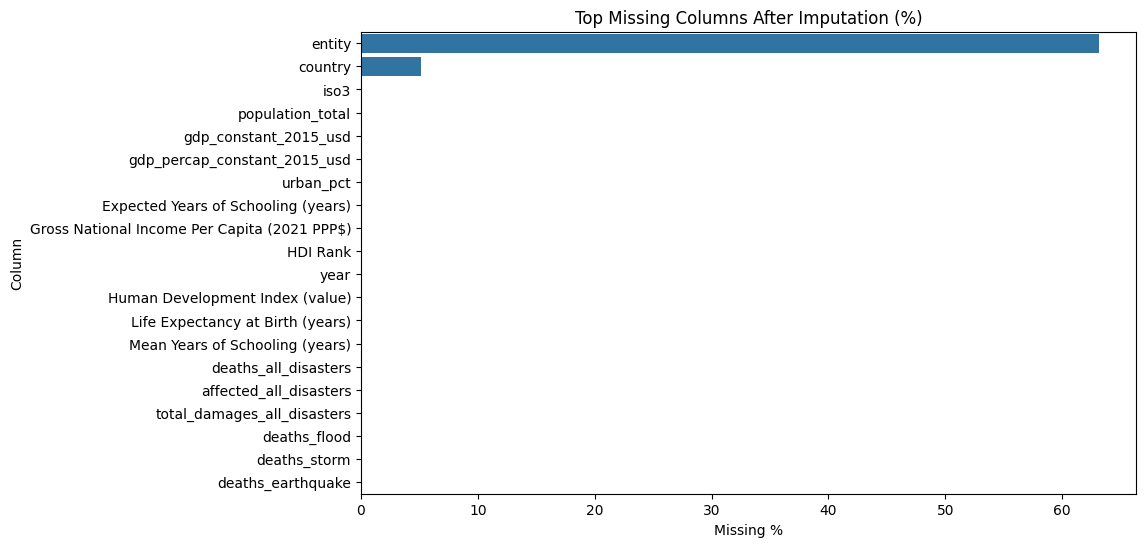

In [ ]:
# visualizing keh after preprocessing dataset, how much reduction in missing values
# 1. entity (63% missing)

# This column is the country name.
# Missing values here come from rows that represent regions, not countries.

# Example region rows:

# “Sub-Saharan Africa”

# “Arab States”

# “Latin America & Caribbean”

# Since you’ll only use country-level data for CRI & DII, this is harmless.

# 2. country (5% missing)

# Same reason — region rows.

# Nothing important is missing from real countries.

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    x=missing_sorted["missing_pct"].head(20),
    y=missing_sorted.index[:20]
)
plt.title("Top Missing Columns After Imputation (%)")
plt.xlabel("Missing %")
plt.ylabel("Column")
plt.show()


In [ ]:
# ------------------ Compute DII and CRI (safe, defensive) ------------------
import pandas as pd
import numpy as np
import os

PROC = "data/processed"
IN = os.path.join(PROC, "final_enhanced_imputed.csv")
OUT = os.path.join(PROC, "final_enhanced_imputed_with_indices.csv")

df = pd.read_csv(IN)
print("Loaded:", df.shape)

eps = 1e-9

# --- helper: get column with possible alternative names ---
def get_col(df, candidates, default=None):
    for c in candidates:
        if c in df.columns:
            return c
    return default

# Column mapping (add alternatives if your dataset differs)
col_population = get_col(df, ["population_total", "population"])
col_deaths_all = get_col(df, ["deaths_all_disasters", "deaths_all"])
col_affected_all = get_col(df, ["affected_all_disasters", "affected_all_disasters"])
col_total_damages = get_col(df, ["total_damages_all_disasters", "total_damages_all"])
col_gdp_percap = get_col(df, ["gdp_percap_constant_2015_usd", "gdp_percap_constant_2015_usd"])
col_gdp = get_col(df, ["gdp_constant_2015_usd", "gdp_constant_2015_usd"])

# HDR components (many sites use long names)
col_hdi = get_col(df, ["Human Development Index (value)", "hdi", "Human Development Index"])
col_life = get_col(df, ["Life Expectancy at Birth (years)", "life_expectancy", "Life expectancy at birth"])
col_mean_school = get_col(df, ["Mean Years of Schooling (years)", "mean_schooling"])
col_expected_school = get_col(df, ["Expected Years of Schooling (years)", "expected_schooling"])
col_gni_ppp = get_col(df, ["Gross National Income Per Capita (2021 PPP$)", "gni_per_capita_ppp", "GNI per capita (2017 PPP$)"])

# Disaster-type death columns
col_deaths_flood = get_col(df, ["deaths_flood","deaths_flood"])
col_deaths_storm = get_col(df, ["deaths_storm","deaths_storm"])
col_deaths_earthquake = get_col(df, ["deaths_earthquake","deaths_earthquake"])
col_deaths_drought = get_col(df, ["deaths_drought","deaths_drought"])
col_deaths_wildfire = get_col(df, ["deaths_wildfire","deaths_wildfire"])
# build list of types present
death_type_cols = [c for c in [col_deaths_earthquake, col_deaths_flood, col_deaths_storm, col_deaths_drought, col_deaths_wildfire] if c]

# --- Compute basic derived rates if not present ---
if "death_rate_per_100k" not in df.columns and col_deaths_all and col_population:
    df["death_rate_per_100k"] = (df[col_deaths_all].astype(float) / df[col_population].replace(0, np.nan)) * 100000
    df["death_rate_per_100k"] = df["death_rate_per_100k"].fillna(0)

if "affected_pct_population" not in df.columns and col_affected_all and col_population:
    df["affected_pct_population"] = (df[col_affected_all].astype(float) / df[col_population].replace(0, np.nan)) * 100
    df["affected_pct_population"] = df["affected_pct_population"].fillna(0)

if "damage_pct_gdp" not in df.columns and col_total_damages and col_gdp:
    df["damage_pct_gdp"] = (df[col_total_damages].astype(float) / df[col_gdp].replace(0, np.nan)) * 100
    df["damage_pct_gdp"] = df["damage_pct_gdp"].fillna(0)

# Convert death_rate to per million (F)
df["deaths_per_million"] = df["death_rate_per_100k"] * 10.0

# --- Severity weight S for DII (fixed weights) ---
# justify: earthquakes cause concentrated fatalities -> higher severity; floods/storms lower
type_weights = {
    "earthquake": 3.0,
    "flood": 1.4,
    "storm": 1.6,
    "drought": 1.2,
    "wildfire": 1.1
}
# compute weighted presence fraction (data-driven)
if death_type_cols:
    # total deaths per row among types
    df["_sum_death_types"] = df[death_type_cols].sum(axis=1)
    # compute weighted sum only when type columns exist
    w_sum = np.zeros(len(df))
    for col in death_type_cols:
        typ = col.split("_")[-1]  # crude but workable
        w = type_weights.get(typ, 1.0)
        w_sum += df[col].fillna(0).astype(float) * w
    # If there are no deaths (w_sum==0) we set S = 1. Otherwise scale S = 1 + normalized(w_sum)
    # normalize w_sum to 0..1 across dataset via log transform
    w_log = np.log1p(w_sum)
    if w_log.max() > 0:
        w_norm = (w_log - w_log.min()) / (w_log.max() - w_log.min())
    else:
        w_norm = w_log * 0.0
    df["S_data"] = 1.0 + w_norm  # S between 1 and 2
else:
    df["S_data"] = 1.0

# Also allow fixed S fallback: e.g., S=1 for all if desired
df["S_fixed"] = 1.0

# Choose S to use (data-driven S_data recommended)
df["S"] = df["S_data"]

# --- Compute DII_raw ---
# DII_raw = (F + Apop) / GDPpc * S
# careful with GDPpc naming
gdp_pc_col = col_gdp_percap if col_gdp_percap else col_gdp
if not gdp_pc_col:
    print("Warning: no GDP per capita column found; DII will use gdp column as proxy")
    gdp_pc_col = col_gdp

# avoid divide by zero
df[gdp_pc_col] = pd.to_numeric(df.get(gdp_pc_col, pd.Series(np.nan, index=df.index)), errors="coerce").fillna(np.nan)

df["DII_raw"] = ((df["deaths_per_million"].fillna(0) + df["affected_pct_population"].fillna(0)) /
                 (df[gdp_pc_col].replace(0, np.nan))) * df["S"]

# handle inf/nan
df["DII_raw"] = df["DII_raw"].replace([np.inf, -np.inf], np.nan).fillna(0)

# scale DII to 0-1 via min-max (for interpretability)
dr = df["DII_raw"].copy()
if dr.max() > dr.min():
    df["DII"] = (dr - dr.min()) / (dr.max() - dr.min())
else:
    df["DII"] = 0.0

# --- CRI construction ---
# A = adaptive capacity composite (use HDI if available, else combine subcomponents)
# We'll compute A_raw as mean of standardized components then min-max scale
A_components = []
if col_hdi:
    A_components.append(df[col_hdi].astype(float).fillna(0))
else:
    if col_life:
        A_components.append(df[col_life].astype(float).fillna(0))
    if col_mean_school:
        A_components.append(df[col_mean_school].astype(float).fillna(0))
    if col_expected_school:
        A_components.append(df[col_expected_school].astype(float).fillna(0))
    if col_gni_ppp:
        A_components.append(df[col_gni_ppp].astype(float).fillna(0))

if len(A_components) == 0:
    # fallback: use gdp per capita as proxy
    A_components = [df[gdp_pc_col].astype(float).fillna(0)]

# create A_raw as mean of normalized components (min-max each then average)
A_norms = []
for series in A_components:
    s = series
    if s.max() > s.min():
        s_norm = (s - s.min()) / (s.max() - s.min())
    else:
        s_norm = s * 0.0
    A_norms.append(s_norm)

A_raw = sum(A_norms) / len(A_norms)
df["A_raw"] = A_raw
# A scaled 0..1
df["A"] = (A_raw - A_raw.min()) / (A_raw.max() - A_raw.min()) if A_raw.max() > A_raw.min() else A_raw*0.0

# Exposure E: frequency * intensity
# frequency = number of disaster types with >0 deaths (simple proxy)
if death_type_cols:
    df["freq_types"] = (df[death_type_cols].fillna(0) > 0).sum(axis=1)
else:
    # fallback: frequency = indicator if any death > 0
    df["freq_types"] = (df[col_deaths_all].fillna(0) > 0).astype(int)

# intensity: normalized deaths_per_million (log transform then min-max)
intensity_log = np.log1p(df["deaths_per_million"].fillna(0))
if intensity_log.max() > intensity_log.min():
    intensity_norm = (intensity_log - intensity_log.min()) / (intensity_log.max() - intensity_log.min())
else:
    intensity_norm = intensity_log*0.0
df["intensity_norm"] = intensity_norm

df["E_raw"] = df["freq_types"] * df["intensity_norm"]
# normalize E
er = df["E_raw"]
df["E"] = (er - er.min()) / (er.max() - er.min()) if er.max() > er.min() else er*0.0

# Vulnerability V: combine deaths_per_million, affected_pct_population, damage_pct_gdp
v_comp = []
for c in ["deaths_per_million", "affected_pct_population", "damage_pct_gdp"]:
    if c in df.columns:
        s = df[c].fillna(0).astype(float)
        # log transform heavy tails for deaths
        if c == "deaths_per_million":
            s = np.log1p(s)
        # min-max
        if s.max() > s.min():
            s = (s - s.min()) / (s.max() - s.min())
        else:
            s = s*0.0
        v_comp.append(s)
if len(v_comp) == 0:
    df["V_raw"] = 0.0
else:
    V_raw = sum(v_comp) / len(v_comp)
    df["V_raw"] = V_raw
    df["V"] = (V_raw - V_raw.min()) / (V_raw.max() - V_raw.min()) if V_raw.max() > V_raw.min() else V_raw*0.0

# CRI raw
df["CRI_raw"] = df["A_raw"] / (df["E_raw"] * (df["V_raw"] + eps) + eps)

# normalize CRI to 0..1 for ease
cr = df["CRI_raw"].fillna(0)
if cr.max() > cr.min():
    df["CRI"] = (cr - cr.min()) / (cr.max() - cr.min())
else:
    df["CRI"] = 0.0

# --- clean up helper internal cols if you want or keep for transparency ---
# Save the dataset with indices
df.to_csv(OUT, index=False)
print("Saved with indices:", OUT)
print("Final shape:", df.shape)

# Print summary stats
print("\nDII: min/max:", df["DII"].min(), df["DII"].max())
print("CRI: min/max:", df["CRI"].min(), df["CRI"].max())

# output has min =0  and max = 0, and it is  not shady bcoz 
# What does min–max normalization ALWAYS produce?

# Minimum becomes exactly 0

# Maximum becomes exactly 1

# This happens mathematically — it is not random or “shady”.
# This is how the transformation works.

# So seeing min=0 and max=1 is the expected behavior.


# Many famous indices use 0–1 scaling:

# Human Development Index (HDI)

# Global Resilience Index

# WorldRiskIndex

# Climate Vulnerability Index

# Credit Risk Scores

# PCA-based normalized components

# Why 0–1?

# ✔ Easy comparison
# ✔ D3 visualizations require bounded values
# ✔ Better for choropleths (color ramps require 0–1)
# ✔ Removes units, making features comparable
# ✔ Useful for weighting and composite scores

# So your teacher expects DII and CRI to be normalized like this

Loaded: (14750, 43)
Saved with indices: data/processed\final_enhanced_imputed_with_indices.csv
Final shape: (14750, 60)

DII: min/max: 0.0 1.0
CRI: min/max: 0.0 1.0


In [2]:
# Prepare tableau_final.csv
import pandas as pd
import os
import numpy as np

IN = "data/processed/final_enhanced_imputed_with_indices.csv"   # input (from R3)
OUT = "data/processed/tableau_final.csv"

df = pd.read_csv(IN)

# --- HDI group (simple bins) ---
hdi_col = next((c for c in df.columns if "Human Development Index" in c or c=="hdi"), None)
def hdi_bin(v):
    try:
        v = float(v)
    except:
        return "Unknown"
    if v < 0.55: return "Low"
    if v < 0.7: return "Medium"
    if v < 0.8: return "High"
    return "Very High"

if hdi_col:
    df["hdi_group"] = df[hdi_col].apply(hdi_bin)
else:
    df["hdi_group"] = "Unknown"

# --- income_group by GDP per capita (constant 2015 USD) ---
gdp_pc_candidates = ["gdp_percap_constant_2015_usd","gdp_percap","gdp_percap_2015"]
gdp_pc_col = next((c for c in gdp_pc_candidates if c in df.columns), None)
def income_bucket(x):
    try:
        x = float(x)
    except:
        return "Unknown"
    if x < 1046: return "Low income"
    if x < 4096: return "Lower middle"
    if x < 12696: return "Upper middle"
    return "High income"

df["income_group"] = df[gdp_pc_col].apply(income_bucket) if gdp_pc_col else "Unknown"

# --- continent: try pycountry_convert if available, else Unknown ---
def try_continent(iso3):
    try:
        import pycountry_convert as pc
        if pd.isna(iso3): return "Unknown"
        # pycountry_convert wants alpha2 or country name mapping; use pycountry to get alpha2
        import pycountry
        country = pycountry.countries.get(alpha_3=str(iso3))
        if country:
            alpha2 = country.alpha_2
            cont_code = pc.country_alpha2_to_continent_code(alpha2)
            mapping = {"AF":"Africa","AS":"Asia","EU":"Europe","NA":"North America","OC":"Oceania","SA":"South America","AN":"Antarctica"}
            return mapping.get(cont_code, "Unknown")
    except Exception:
        return "Unknown"
    return "Unknown"

df["continent"] = df["iso3"].apply(try_continent)

# --- Select useful columns for Tableau (keep any that exist) ---
keep = [
 "iso3","country","year","continent","income_group","hdi_group",
 "deaths_all_disasters","deaths_flood","deaths_storm","deaths_earthquake","deaths_drought","deaths_wildfire",
 "deaths_per_million","affected_pct_population","total_damages_all_disasters","damage_pct_gdp",
 "population_total","gdp_constant_2015_usd","gdp_percap_constant_2015_usd","urban_pct",
 "DII","DII_raw","CRI","CRI_raw","A","E","V","S"
]
keep = [c for c in keep if c in df.columns]

df[keep].to_csv(OUT, index=False)
print("Saved:", OUT, "shape:", df[keep].shape)


Saved: data/processed/tableau_final.csv shape: (14750, 26)
